VQC Accuracy: 0.8


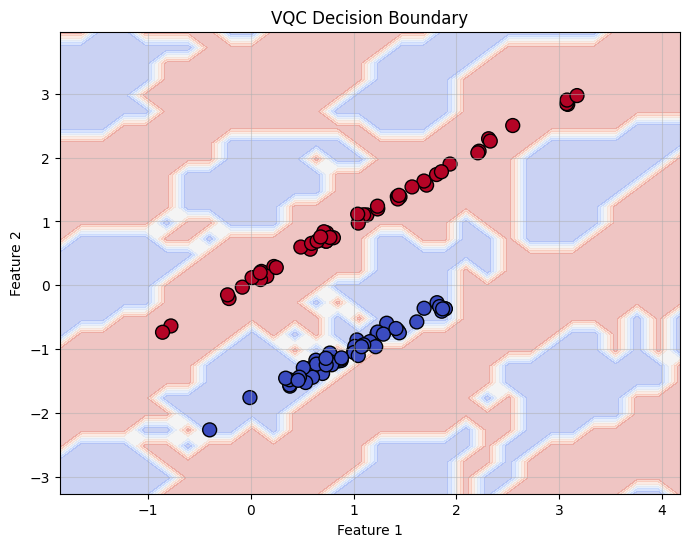

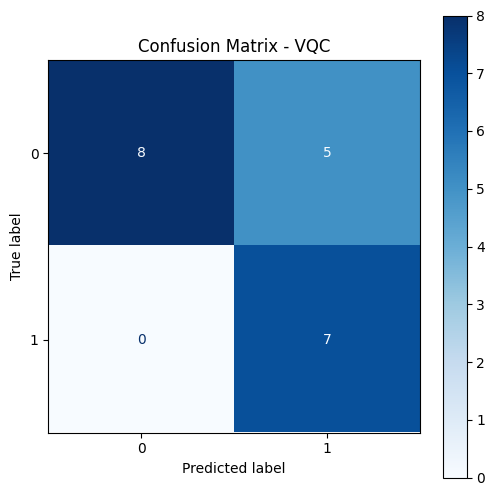

In [2]:
#-------------------------------------------------------------------------
# Variational Quantum Classifier (VQC)  
# Chapter 8 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.0
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas 
# License:  MIT - Citation of this work required
#-------------------------------------------------------------------------
# Qiskit changes frequently. 
# We recommend using the latest version from the book code repository at:
# https://github.com/pedroer/quantum-computing-for-engineers/blob/main/requirements.txt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay

from qiskit import Aer, QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.kernels import QuantumKernel

#-------------------------------------------------------------------------
# Visualization Functions
#-------------------------------------------------------------------------

def plot_decision_boundary(model, X, y):
    """ Function to plot decision boundary """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                         np.linspace(y_min, y_max, 30))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)  # Convert one-hot back to class labels
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="k", s=100)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("VQC Decision Boundary")
    plt.grid(alpha=0.5)
    plt.show()
#-------------------------------------------------------------------------
 
def plot_confusion_matrix(vqc, X_test, y_test):
    """ Function to plot confusion matrix """
    y_pred = vqc.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot back to labels
    y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot back to labels

    fig, ax = plt.subplots(figsize=(6,6))
    ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, cmap="Blues", ax=ax)
    plt.title("Confusion Matrix - VQC")
    plt.grid(False)
    plt.show()
#-------------------------------------------------------------------------

# Generate synthetic dataset
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#-------------------------------------------------------------------------
# Convert labels to one-hot encoding
encoder    = OneHotEncoder(sparse=False)
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh  = encoder.transform(y_test.reshape(-1, 1))

#-------------------------------------------------------------------------
# Define quantum feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
ansatz      = RealAmplitudes(num_qubits=2, reps=1)

# Define quantum kernel for visualization
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend("aer_simulator"))

#-------------------------------------------------------------------------
# Create and train VQC
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(),
    quantum_instance=Aer.get_backend("aer_simulator"),
)

vqc.fit(X_train, y_train_oh)

# Evaluate VQC
accuracy = vqc.score(X_test, y_test_oh)
print("VQC Accuracy:", accuracy)


#-------------------------------------------------------------------------
# Execute visualization functions
plot_decision_boundary(vqc, X, y)
plot_confusion_matrix(vqc, X_test, y_test_oh)
